### Задача 2. На основе данных собранных в задании 1 разбить исходную выборку на кластеры методами кластерного анализа. Цель задания определить  район продажи квартиры на основе данных о ценах, площадях и количестве комнат. Сравнить полученный результат с реальным расположением квартир по районам. В качестве района рассматривать Ленинский, Орджоникидзевский, Правобережный, Орджоникидзевский (Левый берег) и Ленинский (левый берег).

#### Загрузим библиотеки, снова проведем обработку данных, т.к. District будут иначе трансформированны

In [61]:
import pandas as pd
import numpy as np
import random
from scipy.stats import mode
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [62]:
df=pd.read_csv('Train-excel.csv',sep=',')
df.head()

,Id,Type,Rooms,District,Adress,Floor,HouseFloor,Square,LivSquare,KitSquare,Windows,Furniture,Repair,Balcony glassed,WC,Price
0,0,Living,1,Орджоникидзевский,Сиреневый проезд 28,4,9,32.4,18.0,9.0,пластик,да,да,NaN,NaN,2050000
1,1,Living,1,Правобережный,"Им. газеты ""Правда"" 62",1,5,32.0,17.0,6.0,пластик,да,да,NaN,NaN,2050000
2,2,Living,1,Ленинский,Строителей 52,3,3,31.0,NaN,NaN,пластик,да,да,да,NaN,2100000
3,3,Living,1,Ленинский,Ленинградская 19,5,5,30.0,NaN,6.0,пластик,NaN,да,NaN,NaN,2050000
4,4,Living,1,Правобережный,Советской Армии 33/1,9,9,30.0,17.0,6.0,пластик,да,да,да,совм,1490000


##### Удалим лишние признаки и оставим признаки, указанные в задании ЦЕНА, ПЛОЩАДИ (ВСЕ), КОЛ-ВО КОМНАТ.  Целевая переменная -район

In [63]:
df.drop(['Id','Type','Adress','Floor','HouseFloor','Windows','Furniture','Repair','Balcony glassed', 'WC'],axis=1, inplace=True)

df.head()

,Rooms,District,Square,LivSquare,KitSquare,Price
0,1,Орджоникидзевский,32.4,18.0,9.0,2050000
1,1,Правобережный,32.0,17.0,6.0,2050000
2,1,Ленинский,31.0,NaN,NaN,2100000
3,1,Ленинский,30.0,NaN,6.0,2050000
4,1,Правобережный,30.0,17.0,6.0,1490000


In [64]:
df.dtypes

Rooms          int64
District      object
Square       float64
LivSquare    float64
KitSquare    float64
Price          int64
dtype: object

In [65]:
df['District'].value_counts()

Ленинский                          48
Правобережный                      43
Орджоникидзевский                  38
Орджоникидзевский (левый берег)    22
Ленинский(Левый берег)              5
Name: District, dtype: int64

 Т.к. District стал целевой переменной, то dummies уже не использовать, поэтому каждому названию района присвоен номер.

In [66]:
df.District[df.District == 'Орджоникидзевский']=0
df.District[df.District== 'Орджоникидзевский (левый берег)']=1
df.District[df.District== 'Правобережный']=2
df.District[df.District== 'Ленинский']=3
df.District[df.District== 'Ленинский(Левый берег)']=4

In [67]:

df.head()

,Rooms,District,Square,LivSquare,KitSquare,Price
0,1,0,32.4,18.0,9.0,2050000
1,1,2,32.0,17.0,6.0,2050000
2,1,3,31.0,NaN,NaN,2100000
3,1,3,30.0,NaN,6.0,2050000
4,1,2,30.0,17.0,6.0,1490000


In [68]:
df['District'].value_counts()

3    48
2    43
0    38
1    22
4     5
Name: District, dtype: int64

### EDA

In [69]:
df.isna().sum()

Rooms         0
District      0
Square        0
LivSquare    21
KitSquare     8
Price         0
dtype: int64

In [70]:
df.describe()

,Rooms,Square,LivSquare,KitSquare,Price
count,156.000000,156.000000,135.000000,148.000000,1.560000e+02
mean,2.211538,54.698718,36.272296,9.234054,2.888122e+06
std,0.983802,20.730411,17.295014,8.125084,1.280661e+06
min,1.000000,20.600000,10.000000,4.000000,1.000000e+06
25%,1.000000,41.450000,21.500000,6.000000,2.050000e+06
50%,2.000000,54.800000,33.500000,8.000000,2.600000e+06
75%,3.000000,65.000000,45.000000,9.000000,3.312500e+06
max,4.000000,160.000000,120.000000,81.000000,8.490000e+06


In [71]:
medians = df[['LivSquare','KitSquare']].median()

In [72]:
df[['LivSquare','KitSquare']]= df[['LivSquare','KitSquare']].fillna(medians)

In [73]:
df['District'] = df['District'].astype(int)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rooms      156 non-null    int64  
 1   District   156 non-null    int32  
 2   Square     156 non-null    float64
 3   LivSquare  156 non-null    float64
 4   KitSquare  156 non-null    float64
 5   Price      156 non-null    int64  
dtypes: float64(3), int32(1), int64(2)
memory usage: 6.8 KB


In [75]:
df.describe()

,Rooms,District,Square,LivSquare,KitSquare,Price
count,156.000000,156.000000,156.000000,156.000000,156.000000,1.560000e+02
mean,2.211538,1.743590,54.698718,35.899103,9.170769,2.888122e+06
std,0.983802,1.222751,20.730411,16.108787,7.917338,1.280661e+06
min,1.000000,0.000000,20.600000,10.000000,4.000000,1.000000e+06
25%,1.000000,1.000000,41.450000,25.000000,6.000000,2.050000e+06
50%,2.000000,2.000000,54.800000,33.500000,8.000000,2.600000e+06
75%,3.000000,3.000000,65.000000,44.000000,9.000000,3.312500e+06
max,4.000000,4.000000,160.000000,120.000000,81.000000,8.490000e+06


In [76]:
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [77]:
matplotlib.rcParams.update({'font.size': 12})

### Функции, которые будут использоваться

In [78]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [79]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [80]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(12, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [81]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [82]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [83]:
feature_names=['Rooms','Square','LivSquare', 'KitSquare','Price']
feature_names

['Rooms', 'Square', 'LivSquare', 'KitSquare', 'Price']

In [84]:
target=['District']
target

['District']

In [85]:
X=df[feature_names]
y=df[target]

### Разделение на train и test

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### Нормализация и стандартизация

In [87]:
scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

,Rooms,Square,LivSquare,KitSquare,Price
0,-0.5,-0.832677,-0.710526,0.666667,-0.693333
1,0.5,0.277559,0.552632,-0.666667,0.419048


In [88]:
X_train_scaled.describe()

,Rooms,Square,LivSquare,KitSquare,Price
count,104.000000,1.040000e+02,104.000000,104.000000,104.000000
mean,0.115385,-2.294064e-02,0.136822,0.511026,0.230000
std,0.513085,8.517737e-01,0.903568,3.138227,1.044970
min,-0.500000,-1.352362e+00,-1.236842,-1.333333,-1.219048
25%,-0.500000,-6.072835e-01,-0.447368,-0.666667,-0.419048
50%,0.000000,-1.396452e-16,0.000000,0.000000,0.000000
75%,0.500000,3.927165e-01,0.552632,0.333333,0.580952
max,1.000000,4.135827e+00,4.552632,24.333333,4.487619


In [89]:
X_test_scaled.head(2)

,Rooms,Square,LivSquare,KitSquare,Price
0,0.5,0.541339,0.000000,0.000000,-0.533333
1,0.0,-0.076772,0.236842,-0.333333,-0.845714


In [90]:
X_test_scaled.describe()

,Rooms,Square,LivSquare,KitSquare,Price
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.086538,0.016202,0.105162,0.148718,0.198564
std,0.450720,0.747101,0.731492,1.090231,0.829182
min,-0.500000,-1.297244,-1.131579,-1.000000,-1.030095
25%,-0.500000,-0.509843,-0.398684,-0.666667,-0.342857
50%,0.000000,-0.057087,0.000000,0.000000,0.019048
75%,0.500000,0.395669,0.559211,0.333333,0.504762
max,1.000000,2.797244,2.447368,4.900000,3.200000


### Понижение размерности пространства

Лучший результат показан при методе PCA dims=2, dims=1 и dims=3 показали хуже результаты, также были опробовано понижение пространства TSNE, где dims=1 ,2,3 соответственно

In [91]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

,component_1,component_2
0,-0.165520,-1.597982
1,-1.034585,0.812127


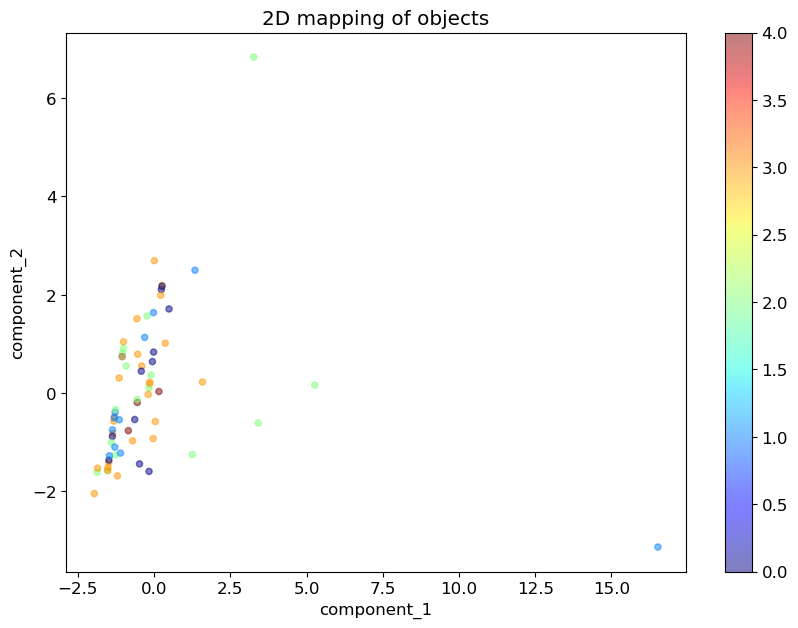

In [92]:
display_components_in_2D_space(components_2d, y_train)

In [93]:
dim_reducer2d_test, components_2d_test = reduce_dims(X_test_scaled, dims=2, method='pca')
components_2d_test.head(2)

,component_1,component_2
0,-0.177655,-0.228569
1,-0.795888,-0.205163


### Кластеризация 

In [94]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

Применим метод "локтя", чтобы узнать оптимальное кол-во K

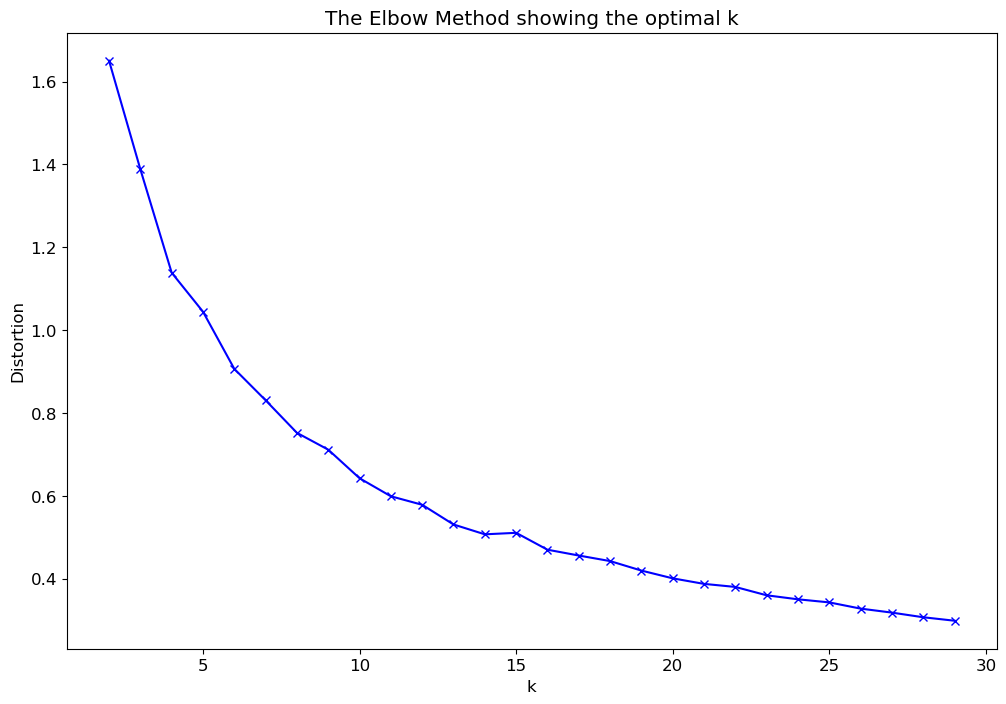

In [95]:
apply_elbow_method(X_train_scaled)

##### Кластеризация Kmeans

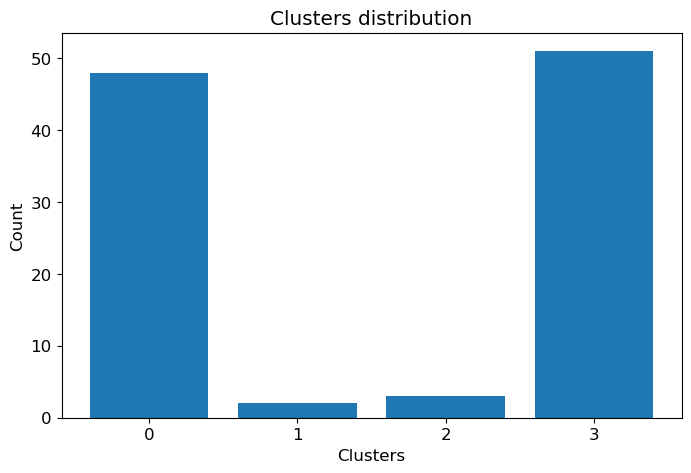

In [96]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_clast = kmeans.fit_predict(components_2d)
labels_clast = pd.Series(labels_clast, name='clusters')
labels_clast_test = kmeans.predict(components_2d_test)
labels_clast_test = pd.Series(labels_clast_test, name='clusters')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [97]:
model = kmeans
model.fit(components_2d, y_train)
predictions = model.predict(components_2d_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.43      0.75      0.55        16
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        15
           3       0.13      0.21      0.16        14
           4       0.00      0.00      0.00         1

    accuracy                           0.29        52
   macro avg       0.11      0.19      0.14        52
weighted avg       0.17      0.29      0.21        52



In [98]:
model.labels_

array([3, 0, 0, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0,
       3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 0, 2, 3, 0, 2, 3, 2, 0, 3, 3, 0, 0,
       3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 1, 0, 3, 0,
       3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0])

In [99]:
predict_answers=model.labels_

Получили датасет с предсказанными данными

In [100]:
DATASET= pd.concat([X_train, y_train], axis=1, join='inner')
DATASET.head()

,Rooms,Square,LivSquare,KitSquare,Price,District
27,1,33.8,20.0,10.0,1690000,3
118,3,62.0,44.0,6.0,3150000,2
117,3,62.0,38.0,7.5,3650000,2
41,1,43.0,32.0,6.0,1700000,1
4,1,30.0,17.0,6.0,1490000,2


Добавим столбец с предсказанными районами

In [101]:
DATASET['Answers'] = predict_answers
DATASET.head()

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers
27,1,33.8,20.0,10.0,1690000,3,3
118,3,62.0,44.0,6.0,3150000,2,0
117,3,62.0,38.0,7.5,3650000,2,0
41,1,43.0,32.0,6.0,1700000,1,3
4,1,30.0,17.0,6.0,1490000,2,3


In [102]:
DATASET['diff']=(DATASET['District'])==(DATASET['Answers'])
DATASET.District[DATASET.District == 0]='Орджоникидзевский'
DATASET.District[DATASET.District == 1]='Орджоникидзевский (левый берег)'
DATASET.District[DATASET.District == 2]='Правобережный'
DATASET.District[DATASET.District == 3]='Ленинский'
DATASET.District[DATASET.District == 4]='Ленинский(Левый берег)'                
DATASET.Answers[DATASET.Answers == 0]='Орджоникидзевский'
DATASET.Answers[DATASET.Answers == 1]='Орджоникидзевский (левый берег)'
DATASET.Answers[DATASET.Answers == 2]='Правобережный'
DATASET.Answers[DATASET.Answers == 3]='Ленинский'
DATASET.Answers[DATASET.Answers == 4]='Ленинский(Левый берег)'
DATASET.head(10)

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers,diff
27,1,33.8,20.0,10.0,1690000,Ленинский,Ленинский,True
118,3,62.0,44.0,6.0,3150000,Правобережный,Орджоникидзевский,False
117,3,62.0,38.0,7.5,3650000,Правобережный,Орджоникидзевский,False
41,1,43.0,32.0,6.0,1700000,Орджоникидзевский (левый берег),Ленинский,False
4,1,30.0,17.0,6.0,1490000,Правобережный,Ленинский,False
32,1,29.7,17.0,5.0,1290000,Правобережный,Ленинский,False
85,2,54.7,40.0,8.0,2100000,Орджоникидзевский (левый берег),Ленинский,False
122,3,62.0,44.0,6.0,3000000,Правобережный,Орджоникидзевский,False
65,2,51.5,33.5,9.0,3550000,Орджоникидзевский,Орджоникидзевский,True
16,1,32.9,19.0,5.0,2000000,Ленинский,Ленинский,True


In [103]:
DATASET['diff'].value_counts()

False    68
True     36
Name: diff, dtype: int64

In [104]:
DATASET['diff'].value_counts('True')

False    0.653846
True     0.346154
Name: diff, dtype: float64

##### Вывод: Модель предсказывает с вероятностью 34%. Этому есть объяснение, т.к. модель не может четко разделить данные на кластеры и объективно разницы между квартирами особо нет, диапазон цен по кол-ву комнат и площади примерно одинаковый. Также был проведен подобный анализ с наибольшим и наименьшим кол-во признаков, данный набор оптимален по предсказанию

In [105]:
rooms_1=pd.DataFrame(DATASET.loc[DATASET['Rooms'] == 1])
rooms_1.head()

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers,diff
27,1,33.8,20.0,10.0,1690000,Ленинский,Ленинский,True
41,1,43.0,32.0,6.0,1700000,Орджоникидзевский (левый берег),Ленинский,False
4,1,30.0,17.0,6.0,1490000,Правобережный,Ленинский,False
32,1,29.7,17.0,5.0,1290000,Правобережный,Ленинский,False
16,1,32.9,19.0,5.0,2000000,Ленинский,Ленинский,True


##### Изучим какие варианты модель предсказывает лучше всего

In [106]:
rooms_1['diff'].value_counts('True')

False    0.580645
True     0.419355
Name: diff, dtype: float64

In [107]:
rooms_2=pd.DataFrame(DATASET.loc[DATASET['Rooms'] == 2])
rooms_2['diff'].value_counts('True')

False    0.75
True     0.25
Name: diff, dtype: float64

In [108]:
rooms_3=pd.DataFrame(DATASET.loc[DATASET['Rooms'] == 3])
rooms_3['diff'].value_counts('True')

False    0.703704
True     0.296296
Name: diff, dtype: float64

In [109]:
rooms_4=pd.DataFrame(DATASET.loc[DATASET['Rooms'] == 4])
rooms_4['diff'].value_counts('True')

True     0.5
False    0.5
Name: diff, dtype: float64

In [110]:
rooms_4.head()

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers,diff
148,4,73.9,52.0,9.0,5100000,Орджоникидзевский,Орджоникидзевский,True
149,4,82.0,33.5,8.0,4500000,Ленинский,Орджоникидзевский,False
144,4,61.0,45.0,7.0,4500000,Орджоникидзевский,Орджоникидзевский,True
151,4,75.0,58.0,9.0,4890000,Орджоникидзевский,Орджоникидзевский,True
142,4,61.0,33.5,8.0,3300000,Правобережный,Орджоникидзевский,False


In [111]:
lenin=pd.DataFrame(DATASET.loc[DATASET['District'] == 'Ленинский'])
lenin['diff'].value_counts('True')

True     0.558824
False    0.441176
Name: diff, dtype: float64

In [112]:
lenin_left=pd.DataFrame(DATASET.loc[DATASET['District'] == 'Ленинский(Левый берег)'])
lenin_left['diff'].value_counts('True')

False    1.0
Name: diff, dtype: float64

In [113]:
ordjo=pd.DataFrame(DATASET.loc[DATASET['District'] == 'Орджоникидзевский'])
ordjo['diff'].value_counts('True')

True     0.727273
False    0.272727
Name: diff, dtype: float64

In [114]:
ordjo_left=pd.DataFrame(DATASET.loc[DATASET['District'] == 'Орджоникидзевский (левый берег)'])
ordjo_left['diff'].value_counts('True')

False    1.0
Name: diff, dtype: float64

In [115]:
pravober=pd.DataFrame(DATASET.loc[DATASET['District'] == 'Правобережный'])
pravober['diff'].value_counts('True')

False    0.964286
True     0.035714
Name: diff, dtype: float64

##### Лучше всего предсказывает Ленинский район  1 комнатные квартиры и Орджоникидзевский район 4 комнатные квартиры

In [116]:
lenin_1_room=pd.DataFrame(DATASET.loc[(DATASET['District'] == 'Ленинский')&(DATASET['Rooms'] == 1)])
lenin_1_room.head(5)

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers,diff
27,1,33.8,20.0,10.0,1690000,Ленинский,Ленинский,True
16,1,32.9,19.0,5.0,2000000,Ленинский,Ленинский,True
28,1,30.0,19.0,6.0,1600000,Ленинский,Ленинский,True
25,1,20.6,20.6,20.6,1133000,Ленинский,Ленинский,True
23,1,41.6,25.0,10.0,2496000,Ленинский,Ленинский,True


In [117]:
lenin_1_room['diff'].value_counts('True')

True     0.928571
False    0.071429
Name: diff, dtype: float64

In [118]:
ordjo_4_room=pd.DataFrame(DATASET.loc[(DATASET['District'] == 'Орджоникидзевский')&(DATASET['Rooms'] == 4)])
ordjo_4_room.head(5)

,Rooms,Square,LivSquare,KitSquare,Price,District,Answers,diff
148,4,73.9,52.0,9.0,5100000,Орджоникидзевский,Орджоникидзевский,True
144,4,61.0,45.0,7.0,4500000,Орджоникидзевский,Орджоникидзевский,True
151,4,75.0,58.0,9.0,4890000,Орджоникидзевский,Орджоникидзевский,True
143,4,88.5,50.0,8.0,5690000,Орджоникидзевский,Орджоникидзевский,True
141,4,75.0,52.0,9.0,4800000,Орджоникидзевский,Орджоникидзевский,True


In [119]:
ordjo_4_room['diff'].value_counts('True')

True    1.0
Name: diff, dtype: float64